In [34]:
import pandas as pd

from src.helper import get_split_data

In [35]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(3)

X = pd.concat([X_trn, X_val], axis='index')
y = pd.Series([*y_trn, *y_val], index=X.index)

In [42]:
from sklearn.metrics import f1_score
import xgboost as xgb

params = {'colsample_bytree': 0.8911140381161952,
          'gamma': 3.916699983542066,
          'learning_rate': 0.2869252951110596,
          'max_depth': 8,
          'n_estimators': 300,
          'reg_alpha': 0.01169394224301264,
          'reg_lambda': 0.0026106240731026313,
          'subsample': 0.8700968394283575
          }

y_train_value_counts = y_trn.value_counts()
ratio = y_train_value_counts[0] / y_train_value_counts[1]

model = xgb.XGBClassifier(
    **params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=ratio
)

model.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred_ = model.predict(X_tst)

y_pred_proba = model.predict_proba(X_tst)

custom_threshold = 0.5
y_pred = (y_pred_proba[:, 1] > custom_threshold).astype(int)

print(y_pred)

f1 = f1_score(y_tst, y_pred, average="binary")
f1

[0 0 0 0 1 0 1 0 0 1]


np.float64(0.3333333333333333)

In [44]:
import shap

shap.initjs()
shap_ex = shap.TreeExplainer(model)
vals = shap_ex(X_tst)

shap_df = pd.DataFrame(vals.values, columns=X_tst.columns)
# print(shap_df)

In [38]:
import numpy as np

print(pd.concat([shap_df.sum(axis='columns').rename('pred') + vals.base_values,
                 pd.Series(y_pred, name='predicted values'),
                 pd.Series(y_tst, name='true values')], axis='columns')
      .assign(prob=lambda adf: (np.exp(adf.pred) / (1 + np.exp(adf.pred))))
      )

       pred  predicted values  true values      prob
0 -0.246169                 0            0  0.438767
1 -1.322904                 0            0  0.210336
2 -0.069337                 0            0  0.482673
3 -1.082613                 0            0  0.253012
4  1.391880                 1            0  0.800892
5 -1.576565                 0            1  0.171282
6  1.776523                 1            0  0.855267
7 -0.841046                 0            0  0.301315
8 -1.320754                 0            1  0.210693
9  0.206987                 1            1  0.551563


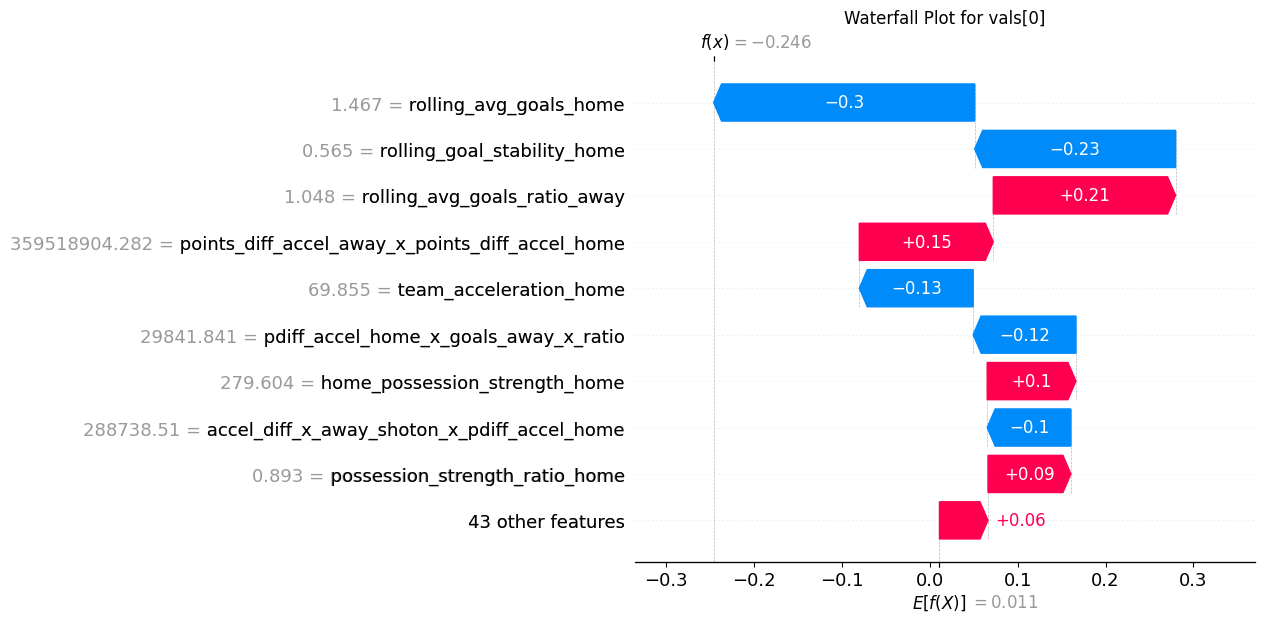

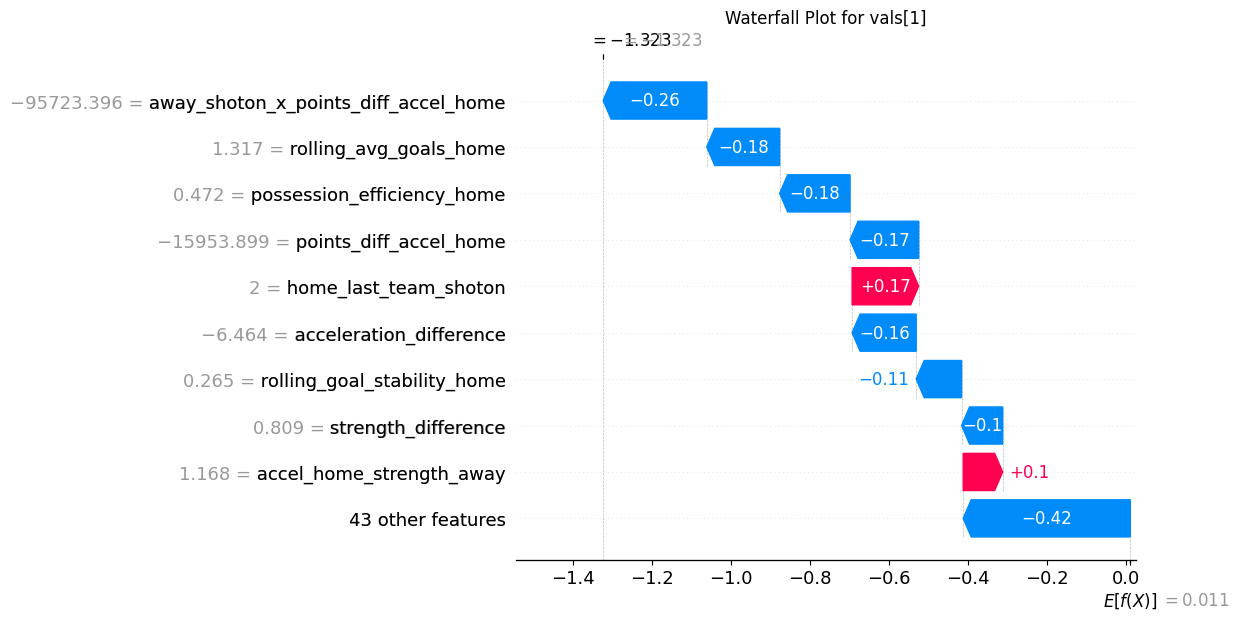

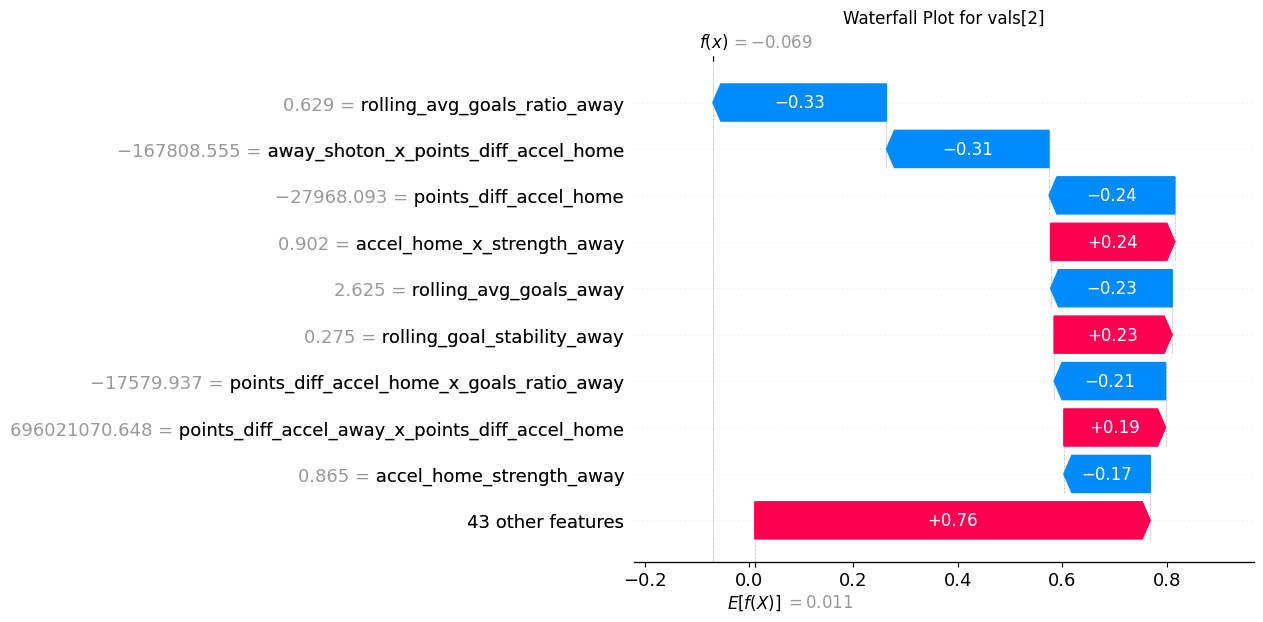

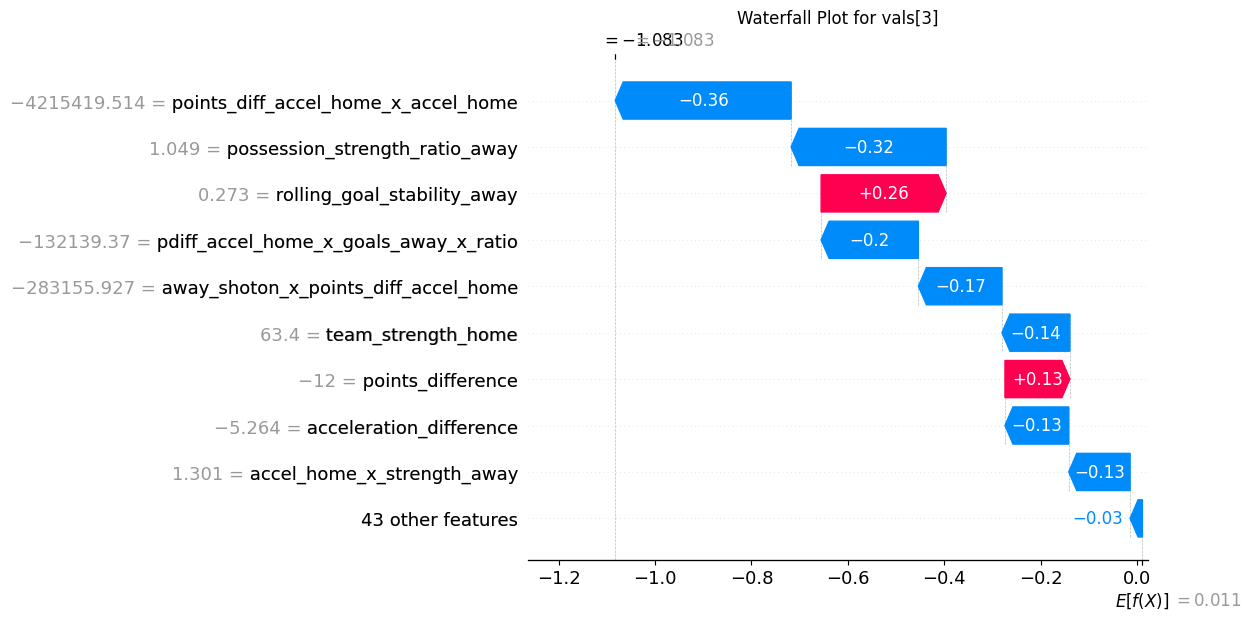

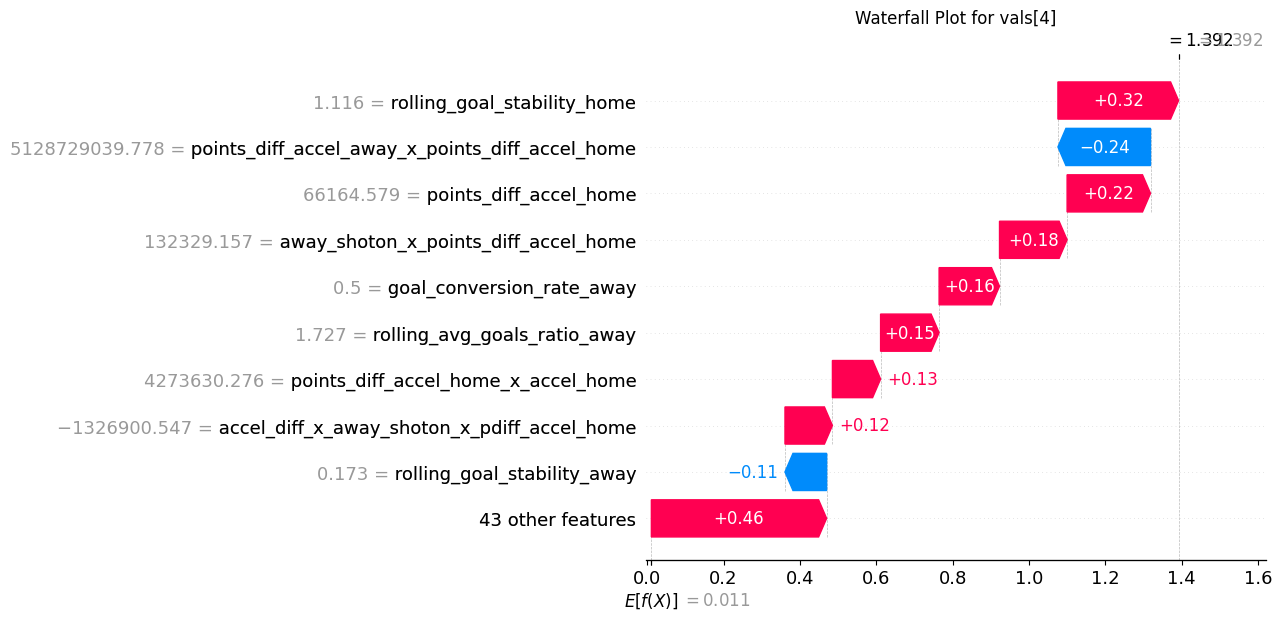

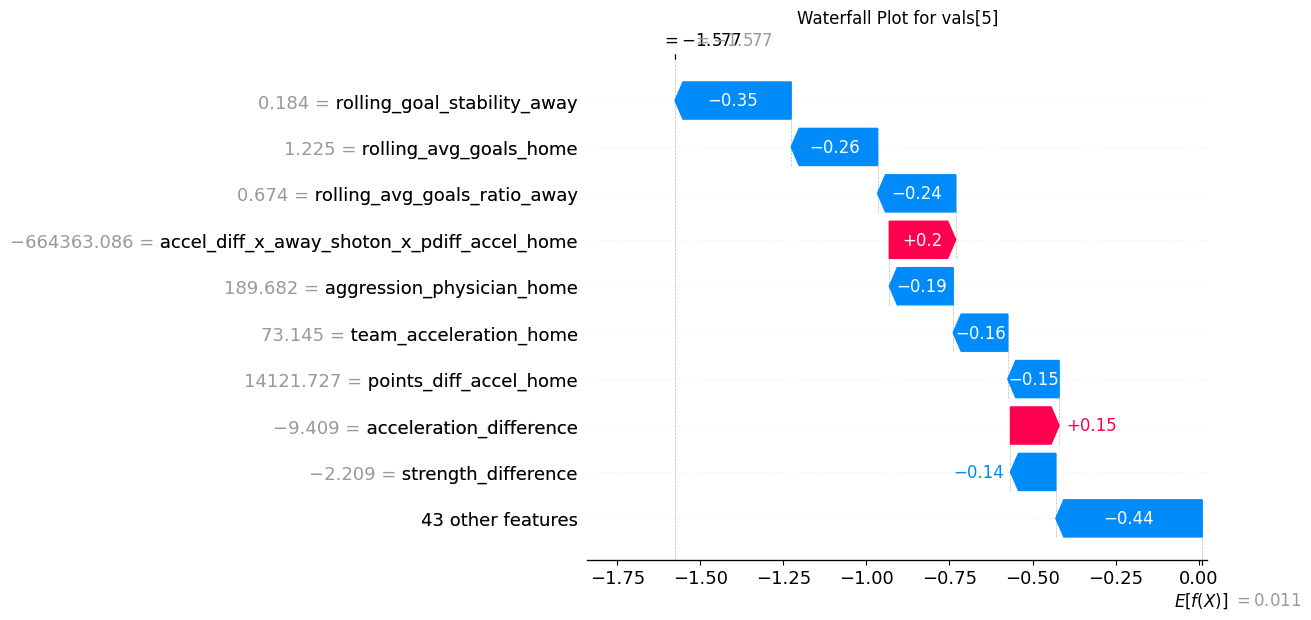

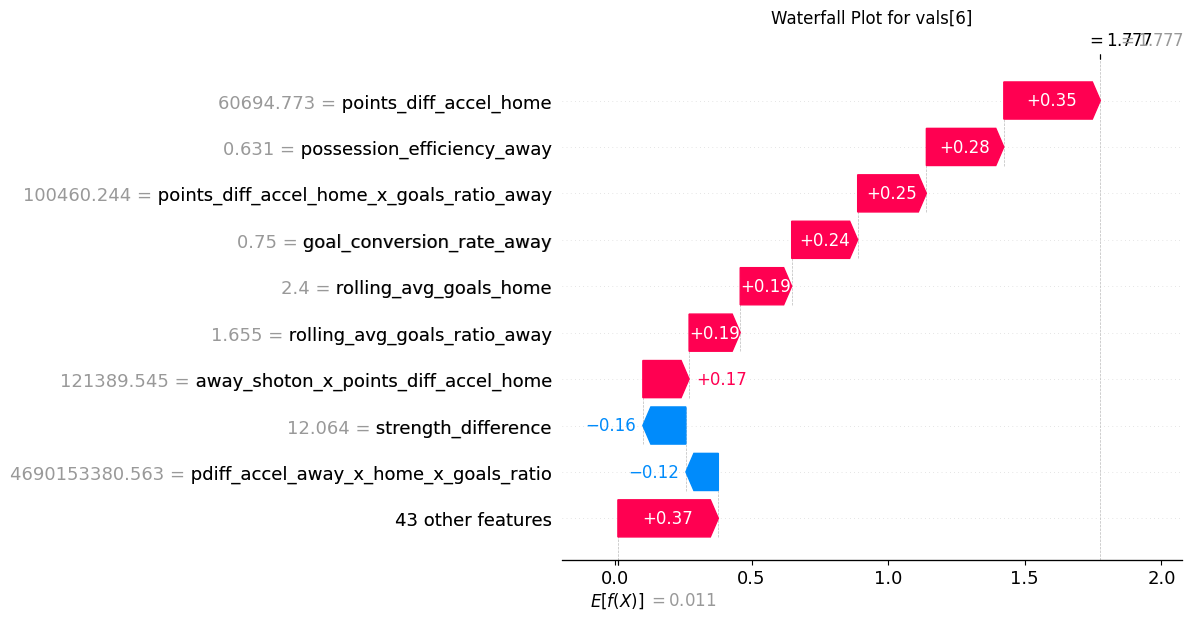

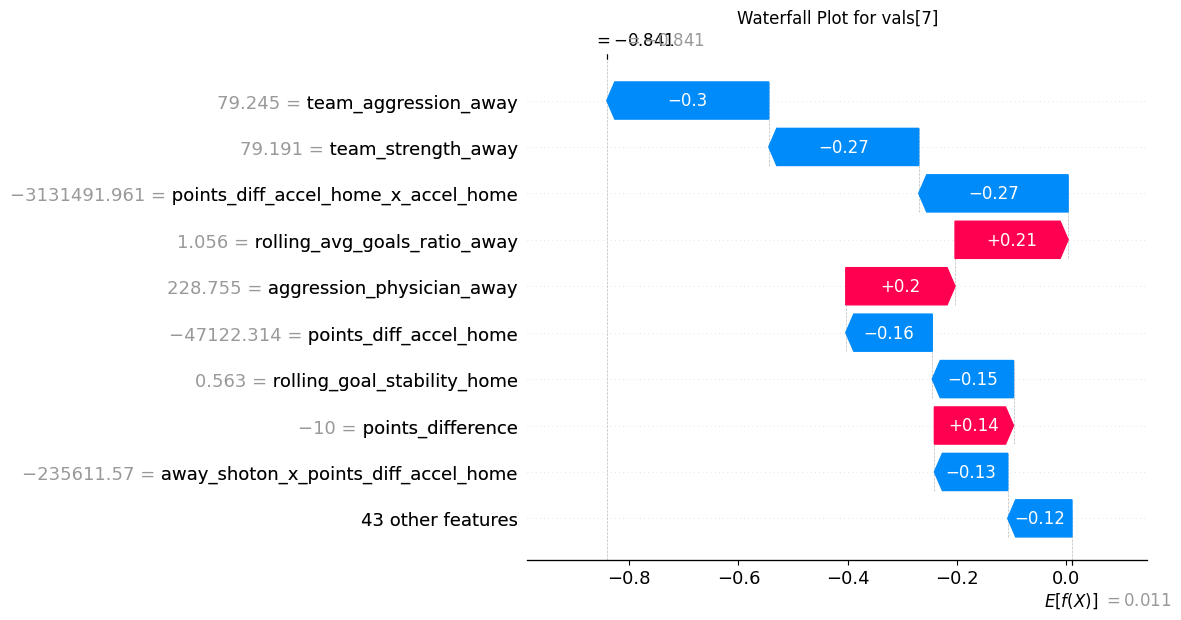

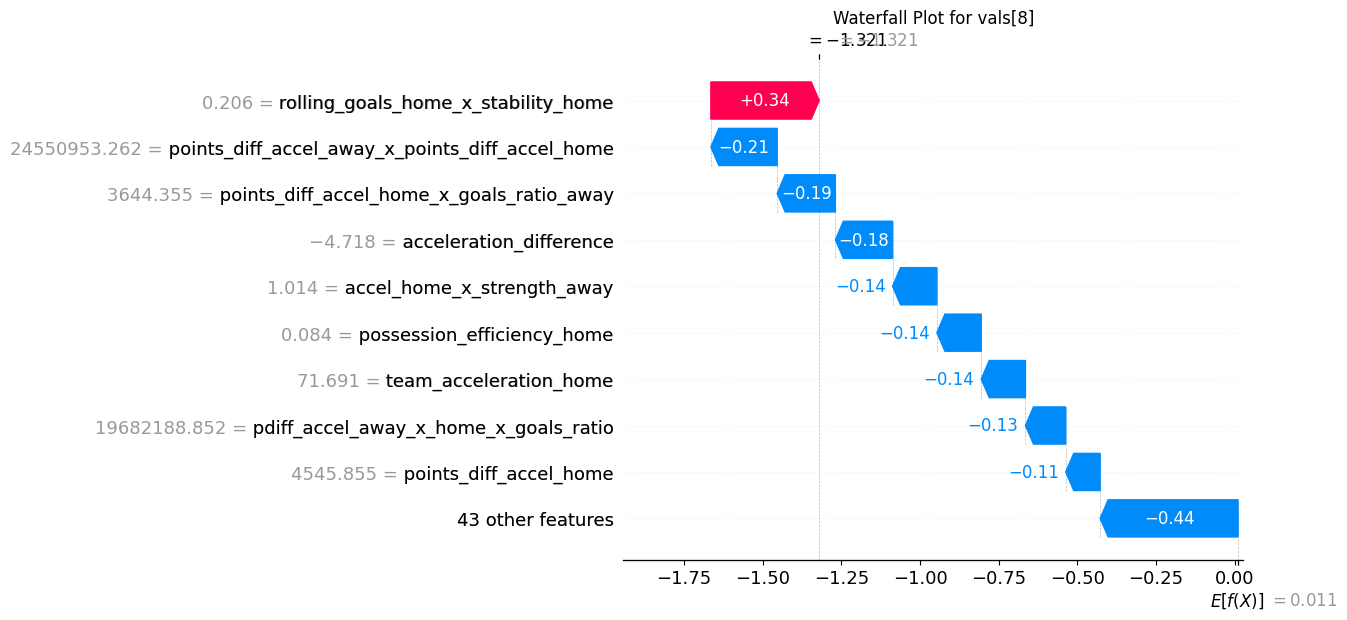

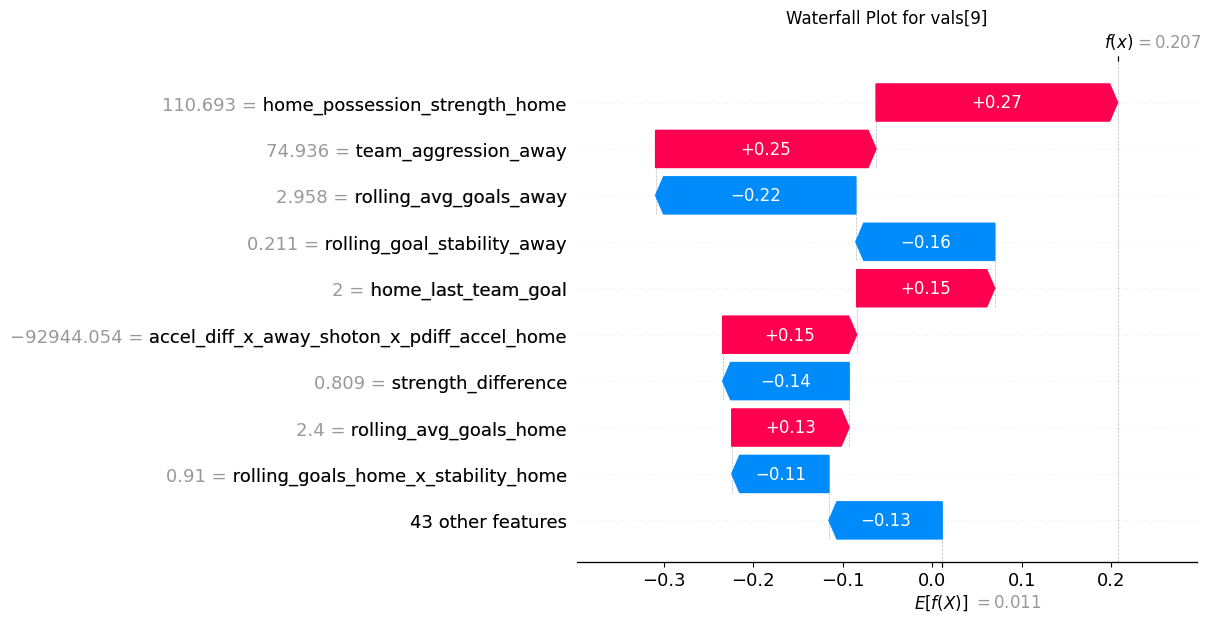

In [39]:
from matplotlib import pyplot as plt

for i, val in enumerate(vals):
    fig = plt.figure(figsize=(8, 4))
    shap.plots.waterfall(val, show=False)
    plt.title(f"Waterfall Plot for vals[{i}]")
    plt.show()

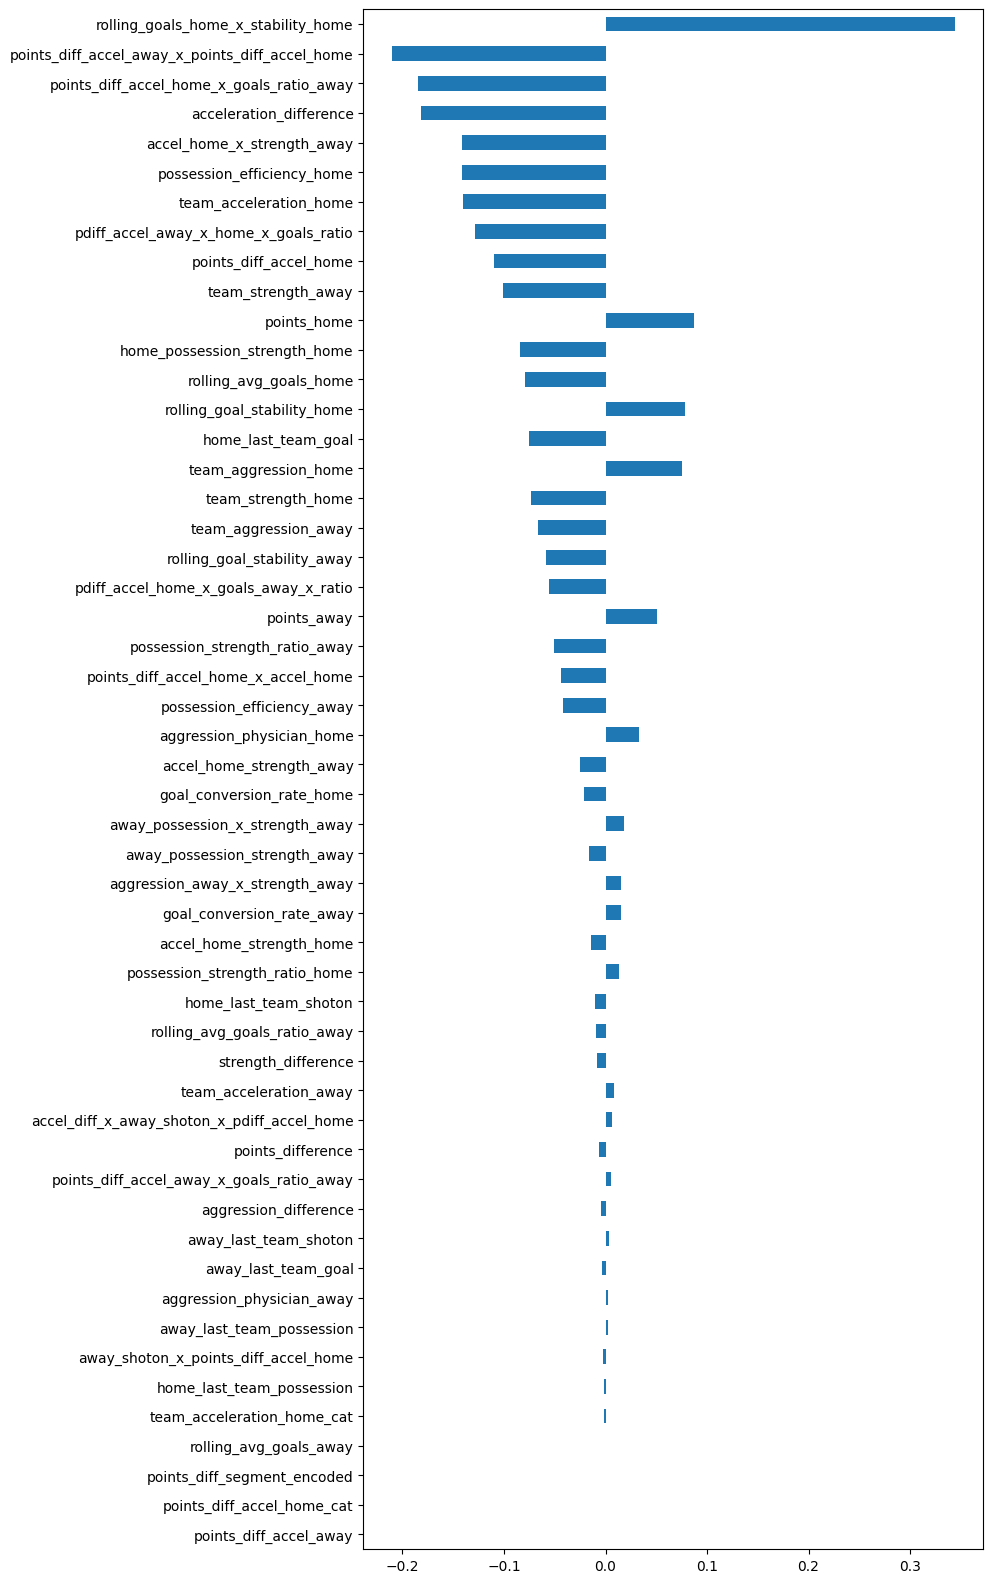

In [40]:
fig, ax = plt.subplots(figsize=(8, 20))
(pd.Series(vals.values[8], index=X_tst.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
 )
plt.show()

In [8]:
features = ['team_aggression_home', 'team_acceleration_away', 'aggression_difference', 'points_diff_accel_home',
            'momentum_multiplier', 'away_last_team_goal']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], title='SHAP values for row 0')
plt.show()

/tmp/ipykernel_352572/1672211698.py:26: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist = (df[columns].hist(ax=ax, color='#bbb'))


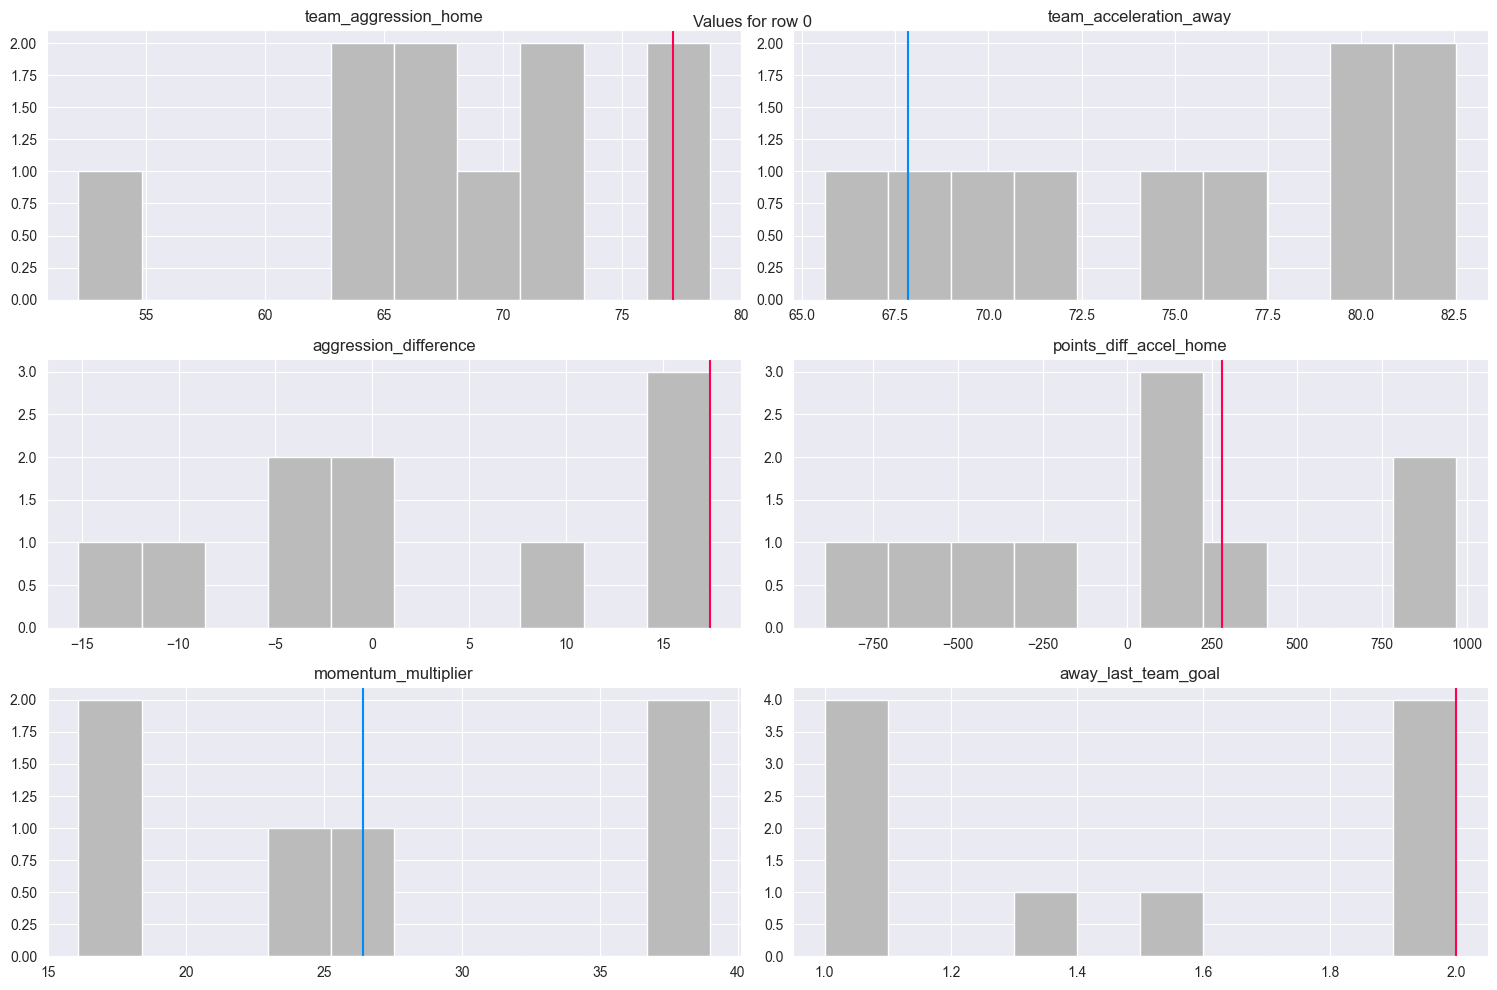

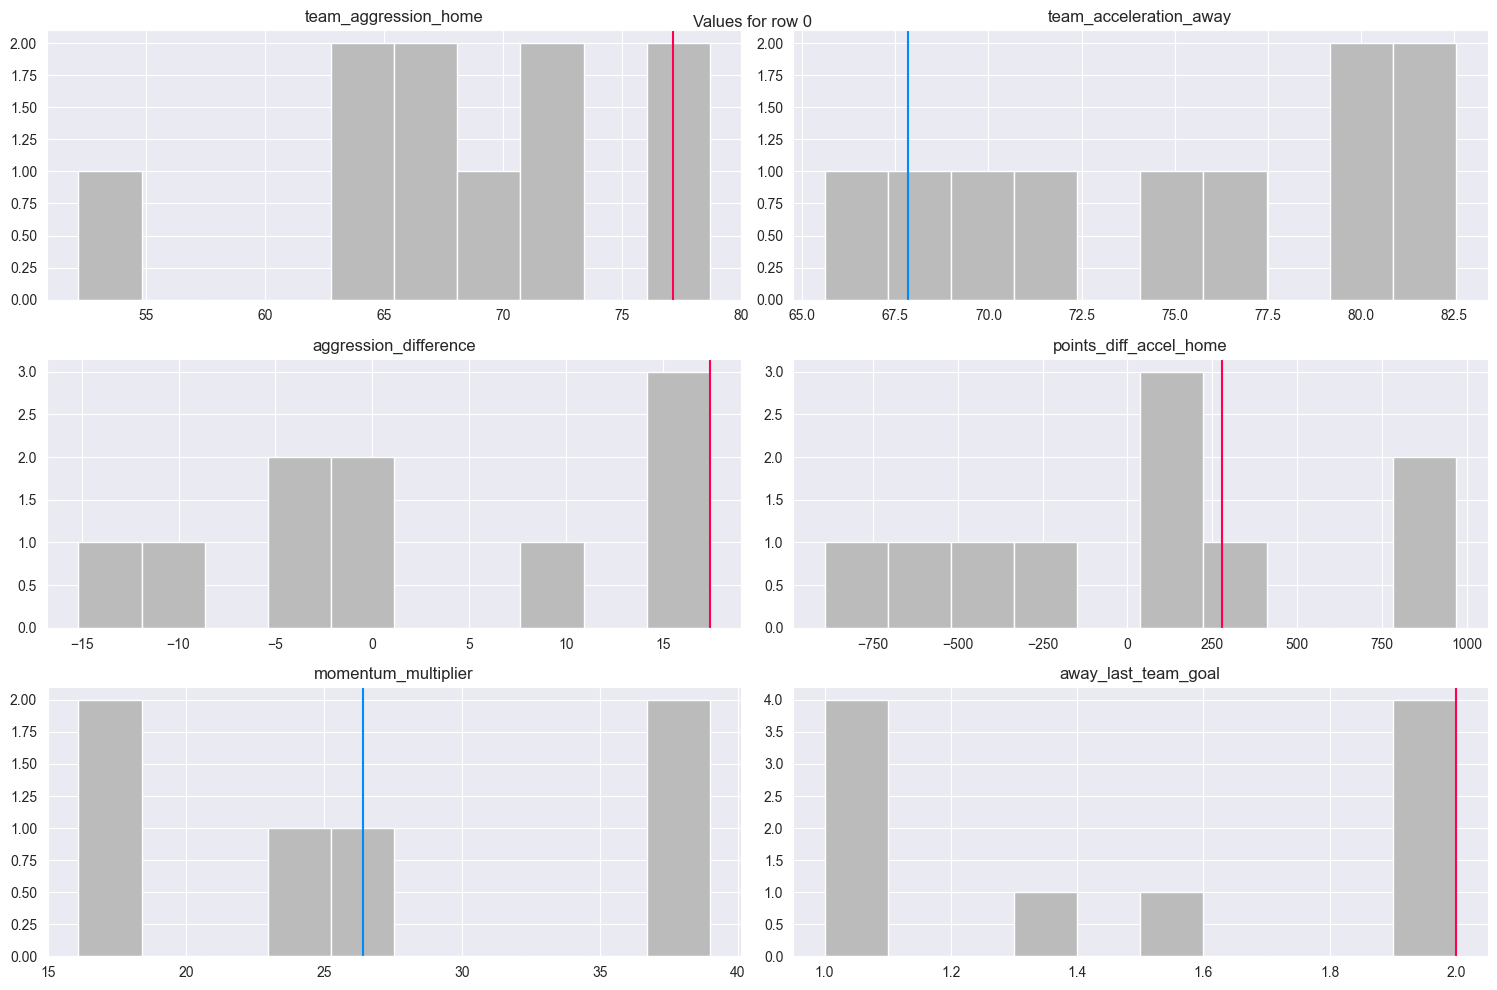

In [76]:
fig = plot_histograms(X_tst, features, X_tst.iloc[0], title='Values for row 0', color='mean')
plt.show()

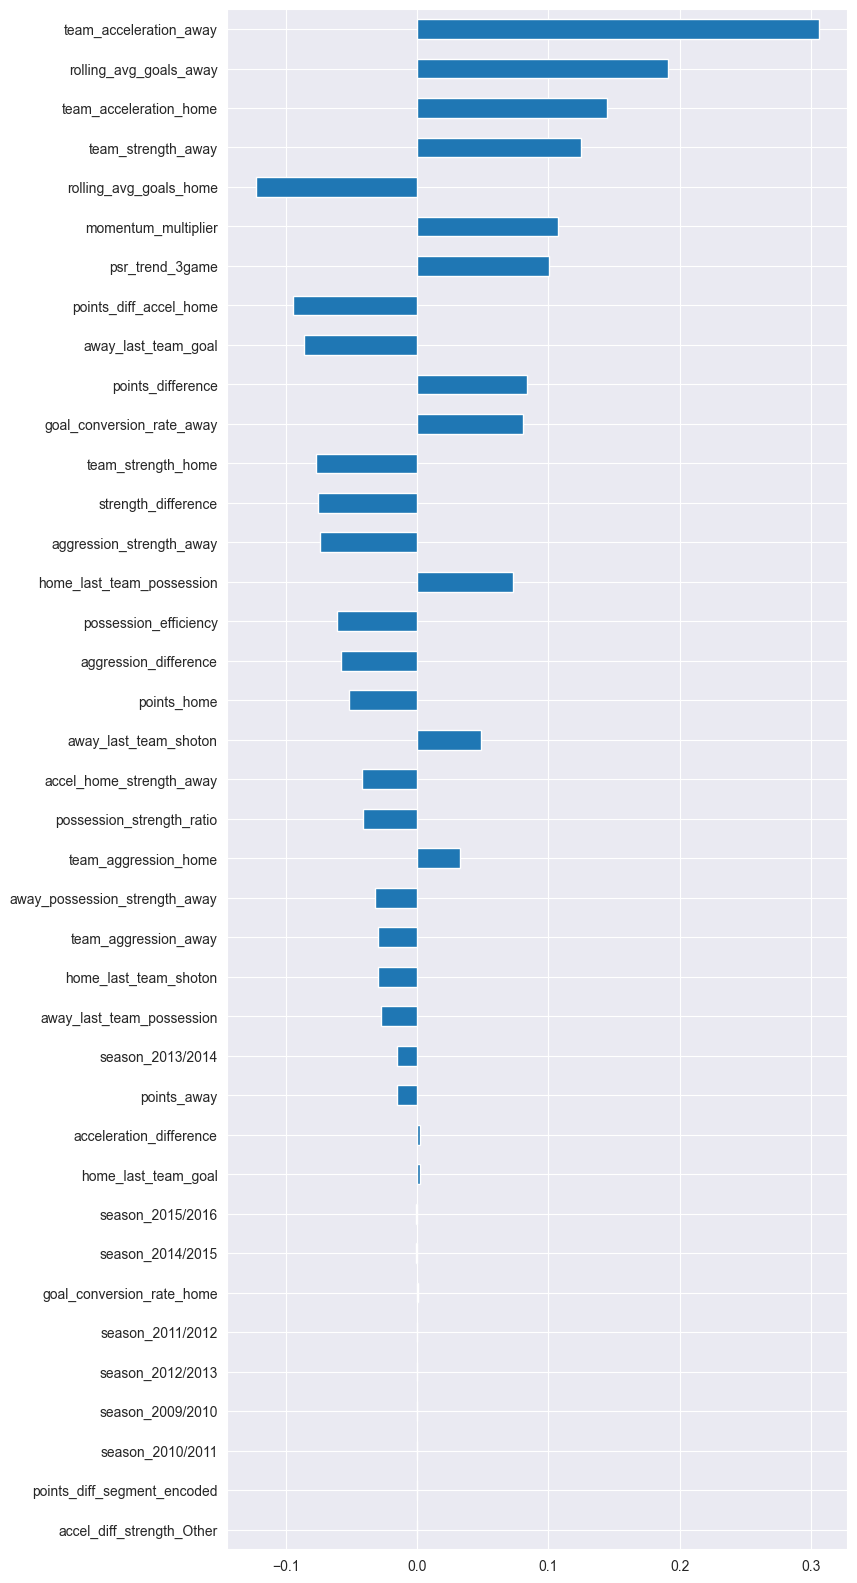

In [81]:
fig, ax = plt.subplots(figsize=(8, 20))
(pd.Series(vals.values[4], index=X_tst.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
 )
plt.show()

In [11]:
target_values_count = y_trn.value_counts()

In [12]:
ratio = target_values_count[0] / target_values_count[1]

np.int64(908)

In [13]:
target_values_count[1]

np.int64(731)